In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install /content/drive/MyDrive/HAI/eTaPR-21.8.2-py3-none-any.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./drive/MyDrive/HAI/eTaPR-21.8.2-py3-none-any.whl


In [5]:
import sys

from pathlib import Path
from datetime import timedelta
import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange


from TaPR_pkg import etapr

In [6]:
import random

random_seed = 42
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # multi-GPU

In [7]:
train_data1 = pd.read_csv("/content/drive/MyDrive/HAI/train1.csv", sep=";", engine="python")
train_data2 = pd.read_csv("/content/drive/MyDrive/HAI/train2.csv", sep=";", engine="python")

In [8]:
TRAIN_DATASET = pd.concat([train_data1, train_data2], axis=0).reset_index(drop=True)

In [9]:
test_data1 = pd.read_csv("/content/drive/MyDrive/HAI/test1.csv", sep=";", engine="python")
test_data2 = pd.read_csv("/content/drive/MyDrive/HAI/test2.csv", sep=";", engine="python")

In [10]:
TEST_DATASET = pd.concat([test_data1, test_data2], axis=0).reset_index(drop=True)

In [99]:
TIMESTAMP_FIELD = "time"
ATTACK_FIELD = "attack"
USELESS_FIELDS = ["attack_P1", "attack_P2", "attack_P3"]
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DATASET.columns.drop(
    [TIMESTAMP_FIELD, ATTACK_FIELD] + USELESS_FIELDS
)

In [16]:
TAG_MIN = TRAIN_DATASET[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DATASET[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [17]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [18]:
TRAIN_DF = normalize(TRAIN_DATASET[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

In [19]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [20]:
boundary_check(TRAIN_DF)

(False, False, False)

In [74]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [100]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DATASET[TIMESTAMP_FIELD], TRAIN_DF, stride=10)

  0%|          | 0/550741 [00:00<?, ?it/s]

# of valid windows: 55069


In [76]:
N_HIDDENS = 100
N_LAYERS = 3
BATCH_SIZE = 1024
# BATCH_SIZE 1024일때

class StackedLSTM(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.LSTM = torch.nn.LSTM(
            input_size=n_tags,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=0,
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.LSTM.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(outs[-1])
        return x[0] + out


class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.rnn = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=0,
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)
        self.relu = torch.nn.ReLU()


    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        # out = self.fc(outs[-1])
        # out = self.relu(out)
        out = self.fc(self.relu(outs[-1]))
        return x[0] + out

In [77]:
MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
MODEL.cuda()

StackedGRU(
  (rnn): GRU(59, 100, num_layers=3, bidirectional=True)
  (fc): Linear(in_features=200, out_features=59, bias=True)
  (relu): ReLU()
)

In [78]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

In [79]:
MODEL.train()
BEST_MODEL, LOSS_HISTORY = train(HAI_DATASET_TRAIN, MODEL, BATCH_SIZE, 70)

training:   0%|          | 0/70 [00:00<?, ?it/s]

In [80]:
with open("model.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL["state"],
            "best_epoch": BEST_MODEL["epoch"],
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

In [81]:
with open("model.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])

<All keys matched successfully>

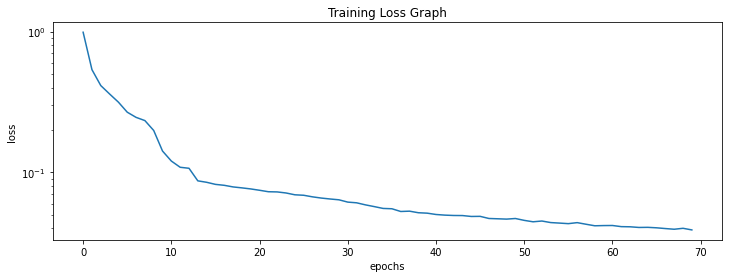

In [82]:
plt.figure(figsize=(12, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

In [101]:
TEST_DF = normalize(TEST_DATASET[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

In [84]:
boundary_check(TEST_DF)

(True, True, False)

In [102]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DATASET[TIMESTAMP_FIELD], TEST_DF, attacks=TEST_DATASET[ATTACK_FIELD]
)

  0%|          | 0/444541 [00:00<?, ?it/s]

# of valid windows: 444482


In [86]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            att.append(np.array(batch["attack"]))
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [87]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, BATCH_SIZE)

CPU times: user 20.1 s, sys: 75.9 ms, total: 20.2 s
Wall time: 20.1 s


In [88]:
CHECK_DIST.shape

(444482, 59)

In [89]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [90]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [91]:
from scipy import signal
b, a = signal.butter(1, 0.1, btype='lowpass')

In [92]:
ANOMALY_SCORE_smooth = signal.filtfilt(b,a,ANOMALY_SCORE)

THRESHOLD = 0.075
LABELS = put_labels(ANOMALY_SCORE_smooth, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (444482,))

In [93]:
ATTACK_LABELS = put_labels(np.array(TEST_DATASET[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (444600,))

In [94]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [103]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(TEST_DATASET[TIMESTAMP_FIELD]))

CPU times: user 52.3 s, sys: 168 ms, total: 52.4 s
Wall time: 52.4 s


In [54]:
ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]

True

In [96]:
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.634 (TaP: 0.619, TaR: 0.650)
# of detected anomalies: 31
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7f397f9fe670>, <TaPR_pkg.DataManage.Range.Range object at 0x7f397f9fe1c0>, <TaPR_pkg.DataManage.Range.Range object at 0x7f397e5da0d0>, <TaPR_pkg.DataManage.Range.Range object at 0x7f397e5da5b0>, <TaPR_pkg.DataManage.Range.Range object at 0x7f397e5da790>, <TaPR_pkg.DataManage.Range.Range object at 0x7f397e5da280>, <TaPR_pkg.DataManage.Range.Range object at 0x7f397f9fe340>, <TaPR_pkg.DataManage.Range.Range object at 0x7f397f9fe9a0>, <TaPR_pkg.DataManage.Range.Range object at 0x7f397f9fe880>, <TaPR_pkg.DataManage.Range.Range object at 0x7f397f9fe730>, <TaPR_pkg.DataManage.Range.Range object at 0x7f397f9feee0>, <TaPR_pkg.DataManage.Range.Range object at 0x7f397f9fe580>, <TaPR_pkg.DataManage.Range.Range object at 0x7f397f9fee50>, <TaPR_pkg.DataManage.Range.Range object at 0x7f397f9fe220>, <TaPR_pkg.DataManage.Range.Range object at 0x7f397f9fe3d0>, <TaPR_pkg.DataMa

In [98]:
rf_result = pd.DataFrame(FINAL_LABELS, columns=["attack"]).reset_index(drop=True)
TEST_DF_RAW = TEST_DATASET.reset_index(drop=True)
submission = pd.concat([TEST_DF_RAW[TIMESTAMP_FIELD], rf_result], axis=1)
submission.columns = ["timestamp", "attack"]
submission.to_csv("./submission2.csv", index=False)